<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-10/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Observations
- Later layers work better with gradcam because they are detecting the object
- Earlier layers are detecting parts or edges so they don't work well.

# **Import Libraries and modules**

In [1]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null
 

  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-s7m67uuh


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, AveragePooling2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, SpatialDropout2D, Add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random
from data_science_utils.vision.keras import *
from data_science_utils import misc
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

from keras.applications.xception import Xception, preprocess_input as ppix, decode_predictions
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as ppiir, decode_predictions


from keras.preprocessing import image
import numpy as np
import cv2

import gc

InteractiveShell.ast_node_interactivity = "all"

# Part 1

In [68]:
model = VGG16(weights="imagenet")
inceptionResnet = InceptionResNetV2(weights="imagenet")
xcep = Xception(weights="imagenet")
from skimage import io



W0704 08:08:07.048781 140273144604544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0704 08:08:08.247212 140273144604544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



91889664/91884032 [==============================] - 3s 0us/step


Note: Doing gradcam from images read from opencv is different from doing it on direct cifar10. OpenCV reads the images as BGR, while plt.imshow expects RGB. 
Also note that you need to know whether your pretrained model expects RGB or BGR. 

In [36]:
misc.print_code(cv2_imshow)

def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks.

  Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
      image.
  """
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display.display(PIL.Image.fromarray(a))



In [0]:
def gradcam(model,layer,img,class_idx,preprocess_func=None,
            show=False,open_cv=True,scale=True):
  x = np.copy(img)
  if preprocess_func is not None:
    x = preprocess_func(x)
  preds = model.predict(x)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  layer_out_channels = last_conv_layer.output_shape[-1]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(layer_out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 1e-4)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
#   print("First")
#   plt.imshow(img)
#   plt.axis("off")
#   plt.show()
  
  if open_cv:
    # print("Second P1")
    # cv2_imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    # print("Second P2")
    # cv2_imshow(img)
   
  
  
#   print("Third")
#   plt.imshow(img)
#   plt.axis("off")
#   plt.show()
  
#   print("done. results..")
  superimposed_img = 0.5*(img) + 0.5*heatmap
  superimposed_img = superimposed_img
  if scale:
    img = img/255
    heatmap = heatmap/255
    superimposed_img = superimposed_img/255
  if show:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    plt.imshow(heatmap)
    plt.axis("off")
    plt.show()
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()
  return img,heatmap,superimposed_img


def show_examples_with_gradcam(model,layer,X,class_idxs,classes=None,preprocess_func=None,image_size_multiplier=3):
  columns = 5
  rows = int(np.ceil(len(X) / columns))
  
  fig_height = rows * image_size_multiplier * 3
  fig_width = columns * image_size_multiplier
  fig = plt.figure(figsize=(fig_width, fig_height))
  outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
  for i in range(rows*columns):
    if i>=len(X):
      break
    x = X[i]
    y = class_idxs[i]
    img,heatmap,superimposed_img = gradcam(model,layer,x,y,preprocess_func=preprocess_func,show=False,open_cv=False)
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.0, hspace=0.15)
    imgs = [img,heatmap,superimposed_img]
    label = classes[y] if classes is not None else ""
    titles = [(""+label).replace(' ', '\n'),"HeatMap","SuperImposed Image"]
    for j in range(3):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(imgs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[j])
        fig.add_subplot(ax)
  
  fig.show()

In [0]:
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


pp = lambda x: preprocess_input(np.expand_dims(image.img_to_array(x), axis=0))


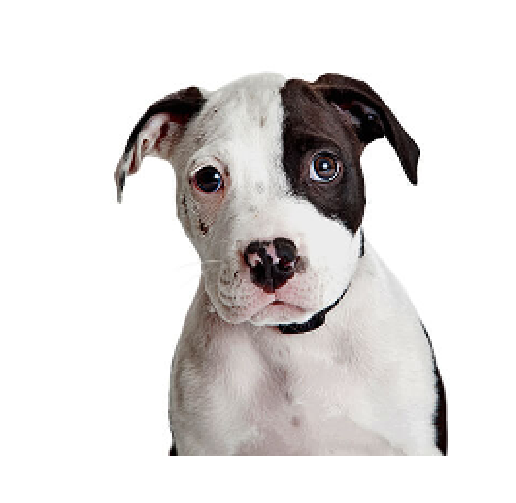

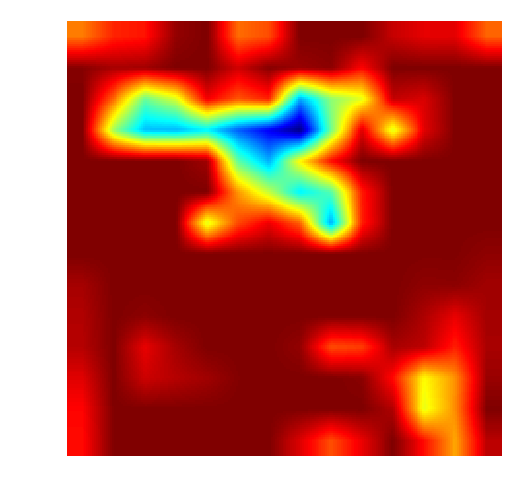

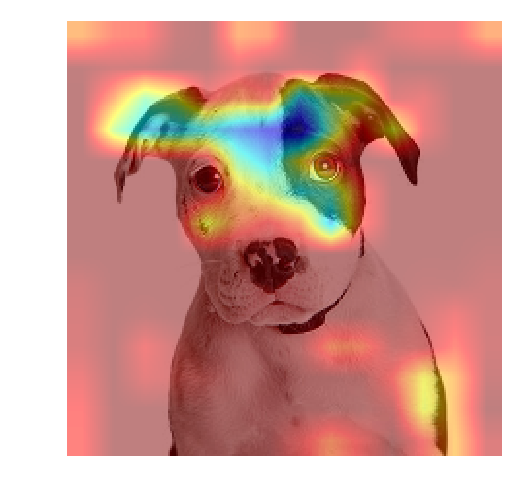

In [62]:
_ = gradcam(model,"block5_conv1",dog,180,preprocess_func=pp,show=True,open_cv=False)

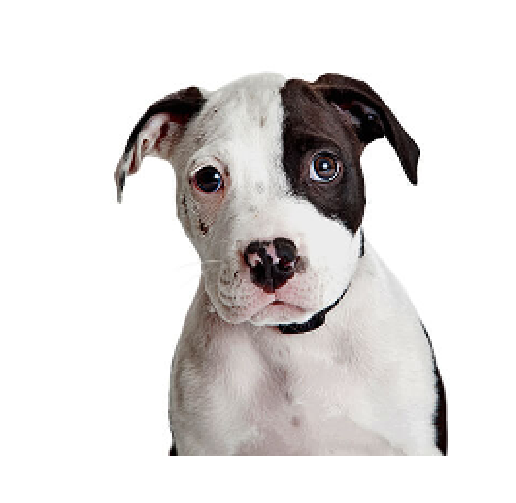

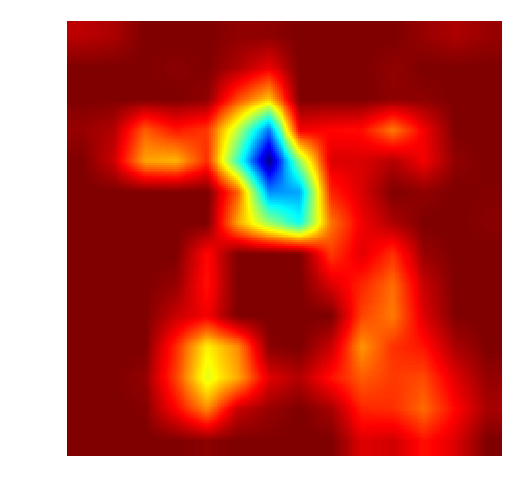

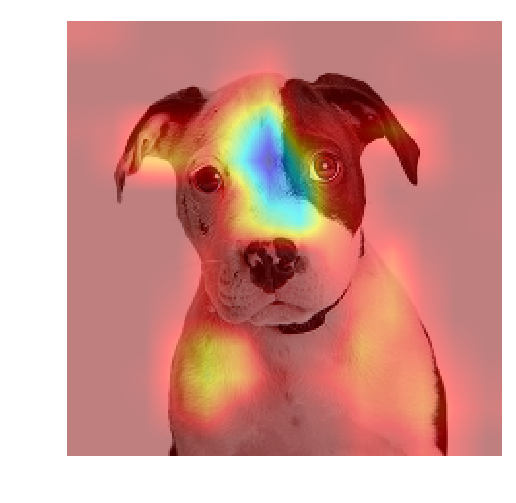

In [63]:

_ = gradcam(model,"block5_conv2",dog,180,preprocess_func=pp,show=True,open_cv=False)
# 230 229 200 153


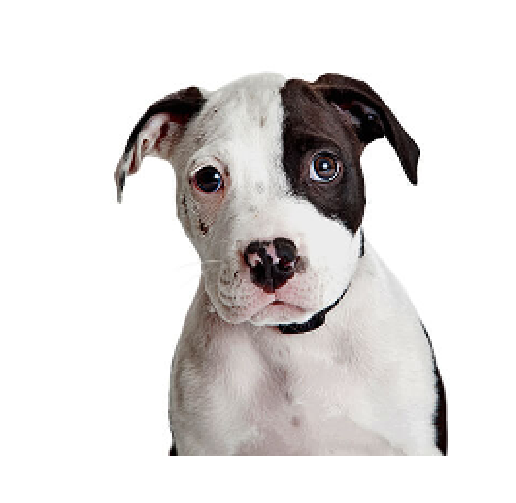

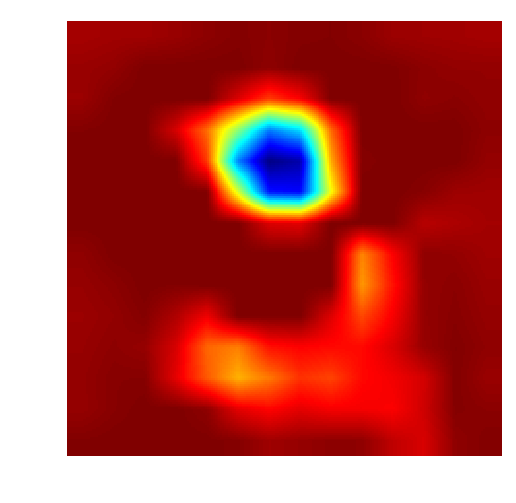

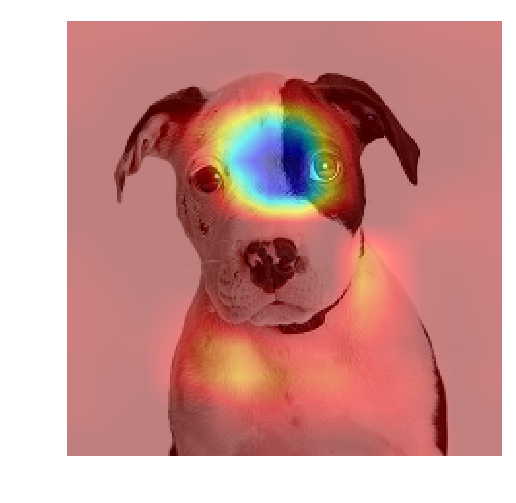

In [64]:
_ = gradcam(model,"block5_conv3",dog,180,preprocess_func=pp,show=True,open_cv=False)

## Lets detect different dogs in this image

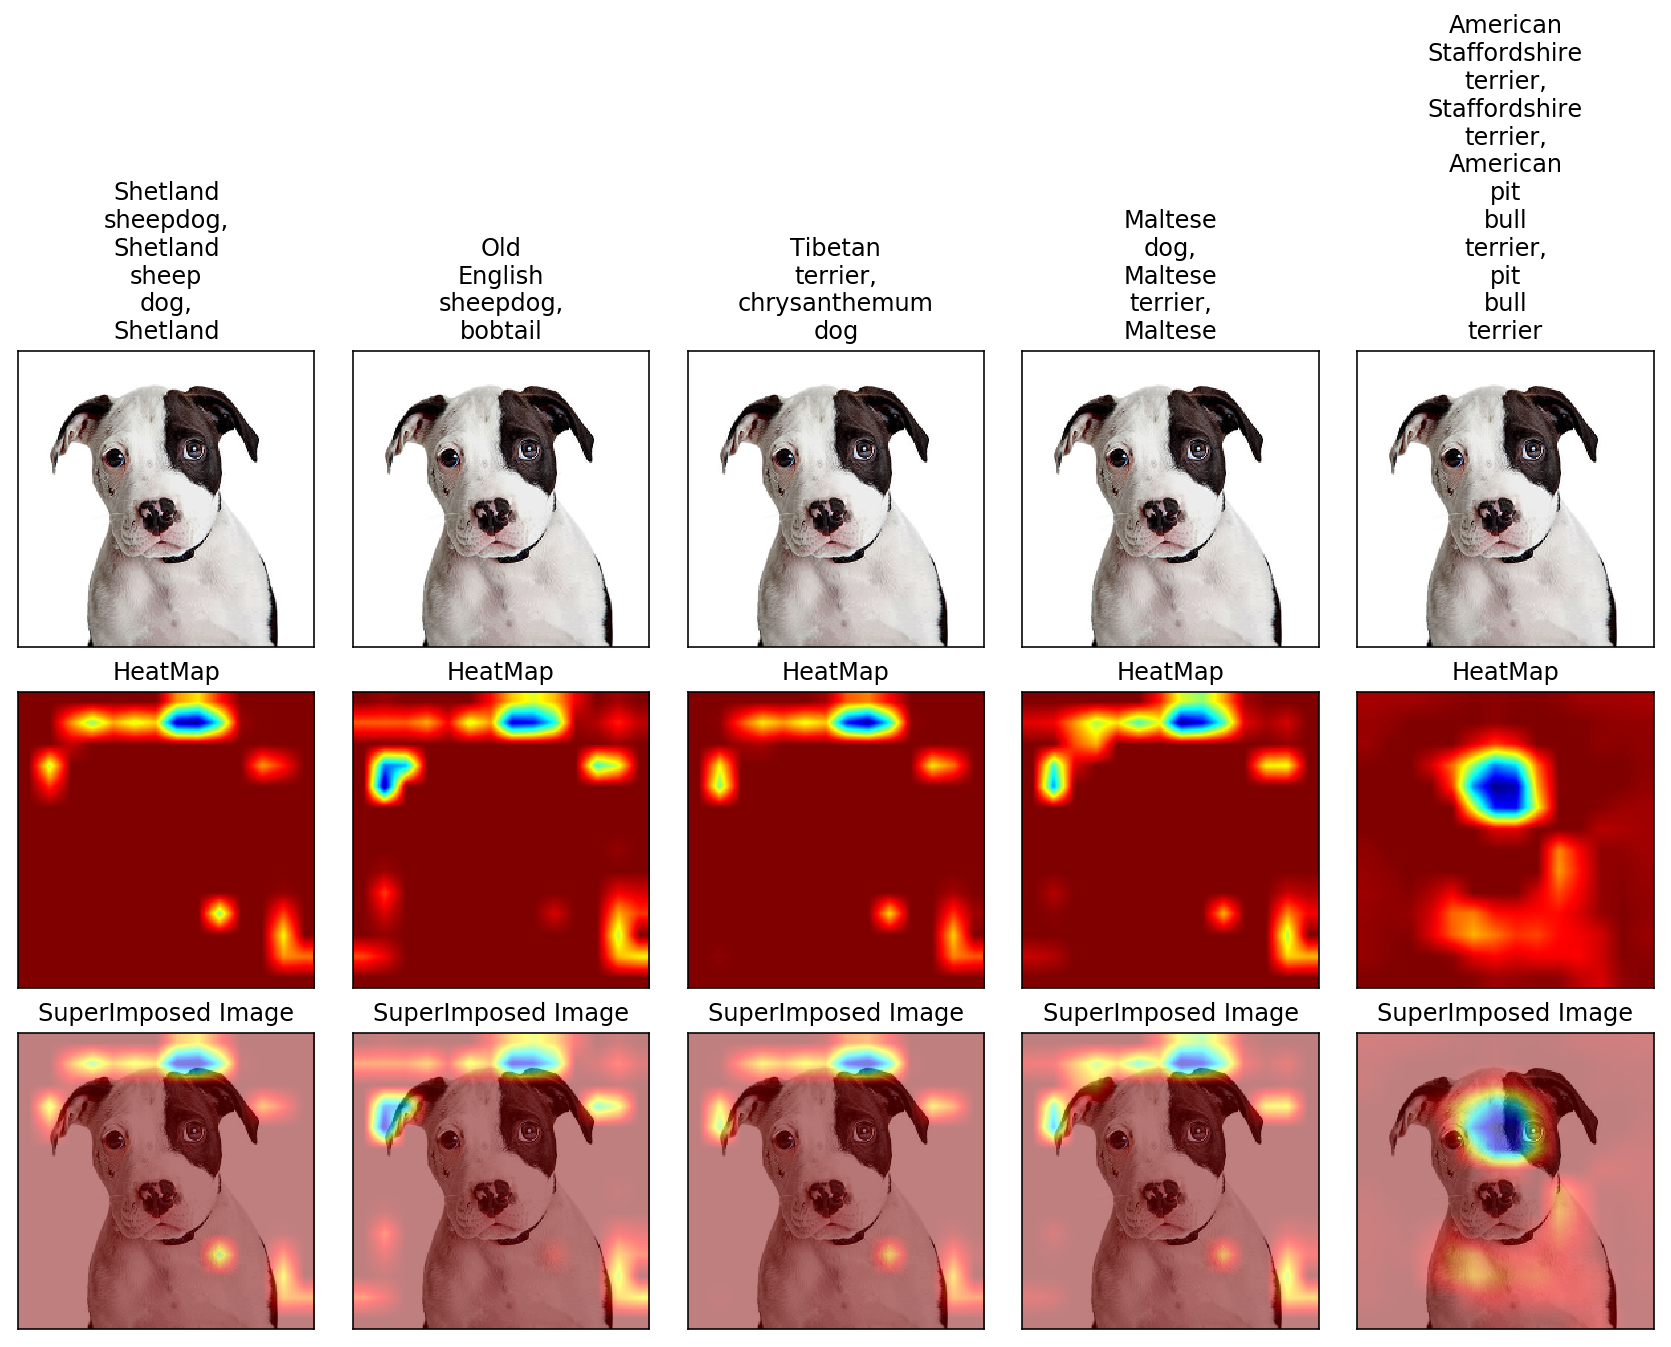

In [65]:
show_examples_with_gradcam(model,"block5_conv3",[dog,dog,dog,dog,dog],[230, 229, 200, 153, 180],preprocess_func=pp,classes=get_imagenet_labels())

## Lets detect sunglasses in doggo :D

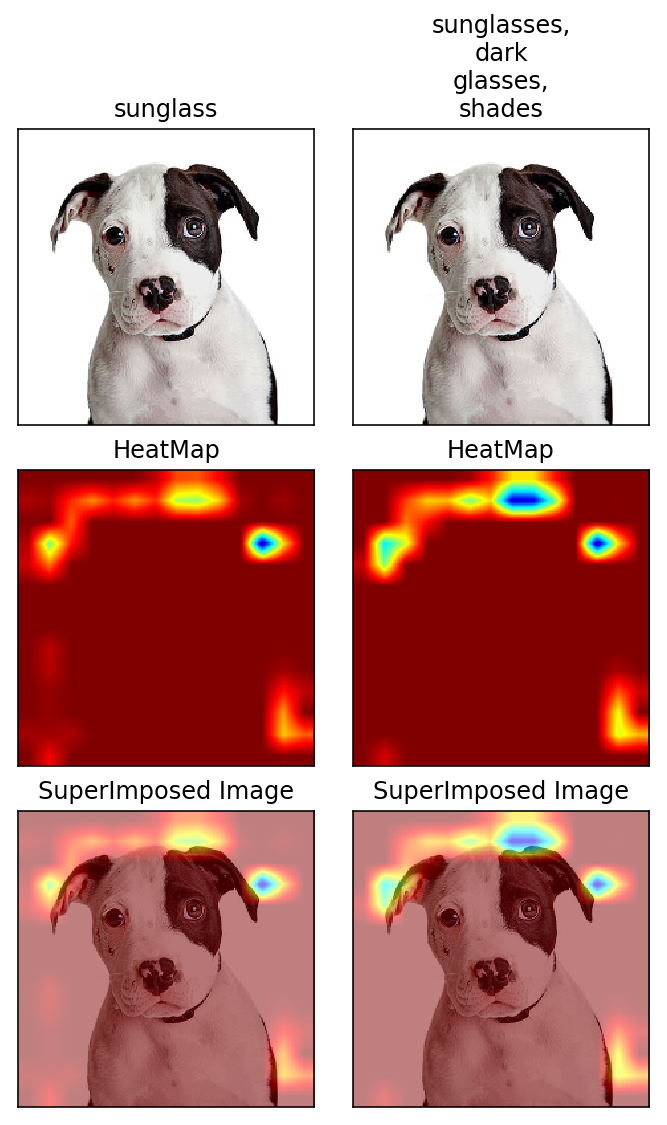

In [60]:
show_examples_with_gradcam(model,"block5_conv3",[dog,dog],[836, 837],preprocess_func=pp,classes=get_imagenet_labels())

## Now Sunglasses on RDJ

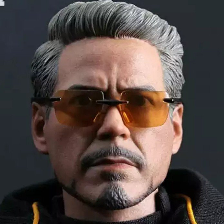

In [54]:
# Uploaded image cause link gave HTTP 403: Forbidden
rdj = io.imread("rdj_glasses.jpg")
rdj = cv2.resize(rdj, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
cv2_imshow(cv2.cvtColor(rdj, cv2.COLOR_BGR2RGB))

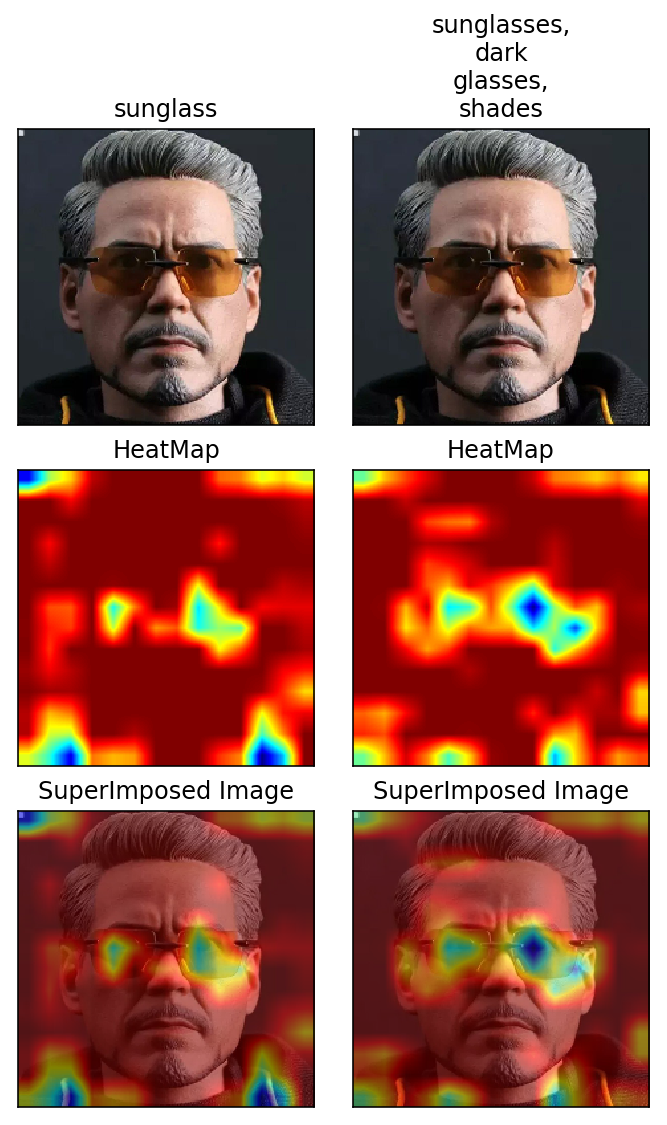

In [59]:
show_examples_with_gradcam(model,"block5_conv1",[rdj,rdj],[836, 837],preprocess_func=pp,classes=get_imagenet_labels())

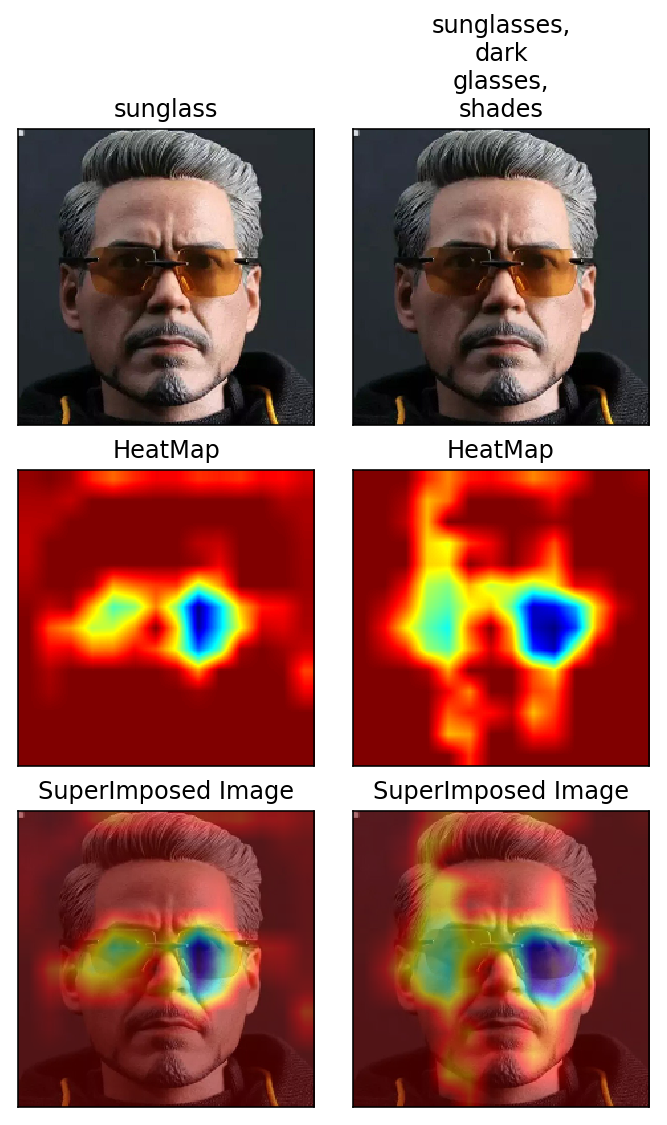

In [57]:
show_examples_with_gradcam(model,"block5_conv2",[rdj,rdj],[836, 837],preprocess_func=pp,classes=get_imagenet_labels())

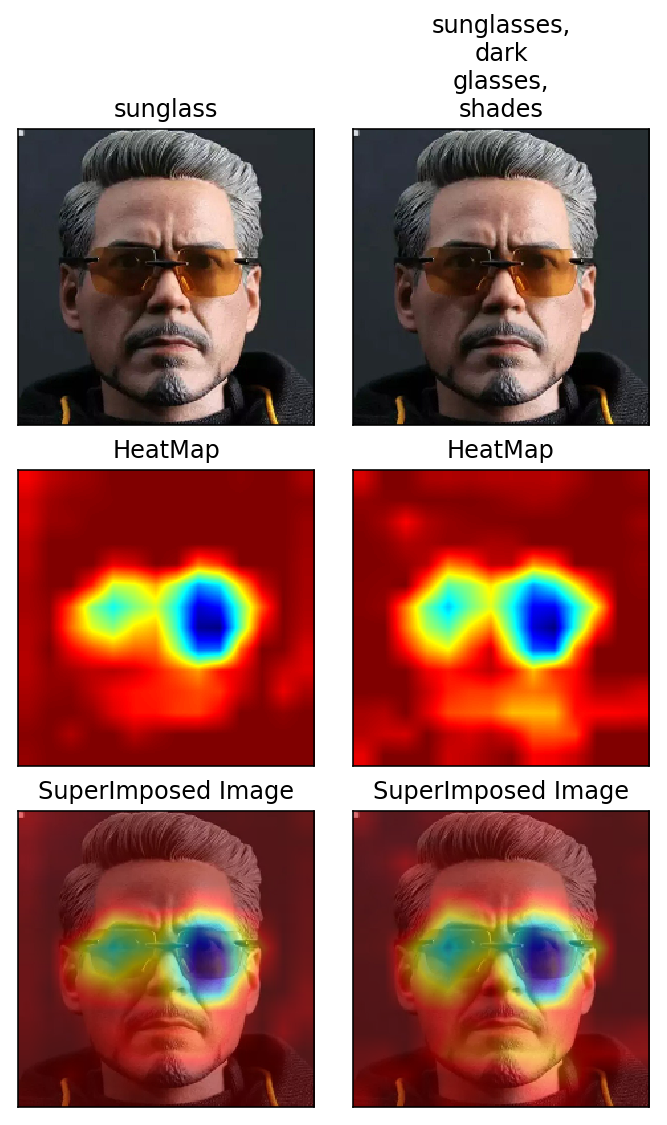

In [58]:
show_examples_with_gradcam(model,"block5_conv3",[rdj,rdj],[836, 837],preprocess_func=pp,classes=get_imagenet_labels())

## Doggo with InceptionResNetV2 and xception net

In [80]:
inceptionResnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

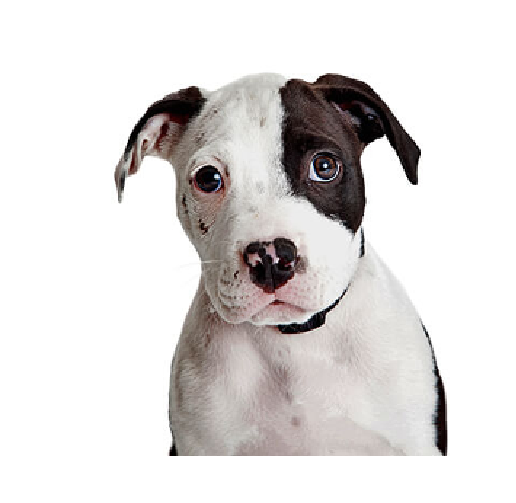

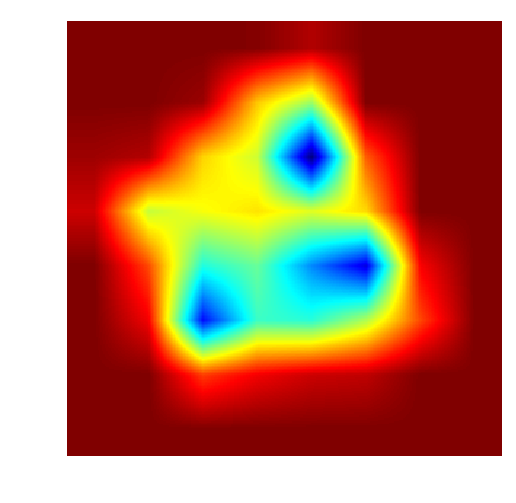

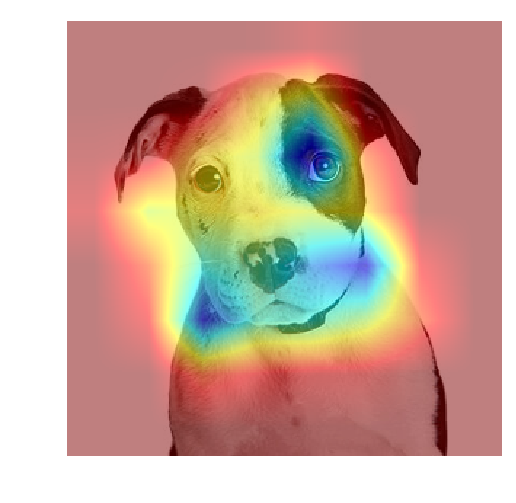

In [71]:
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)


ppi = lambda x: ppiir(np.expand_dims(image.img_to_array(x), axis=0))

_ = gradcam(inceptionResnet,"conv_7b",dog,180,preprocess_func=ppi,show=True,open_cv=False)

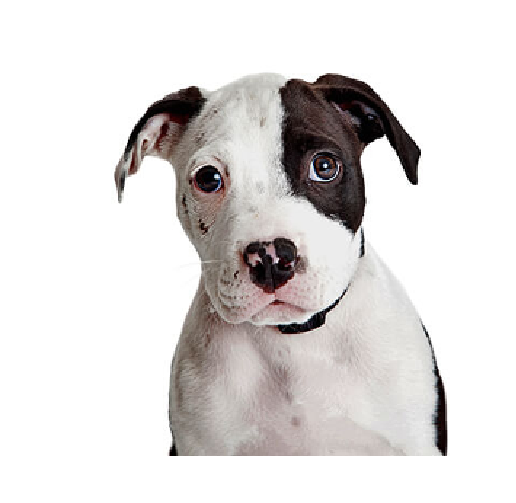

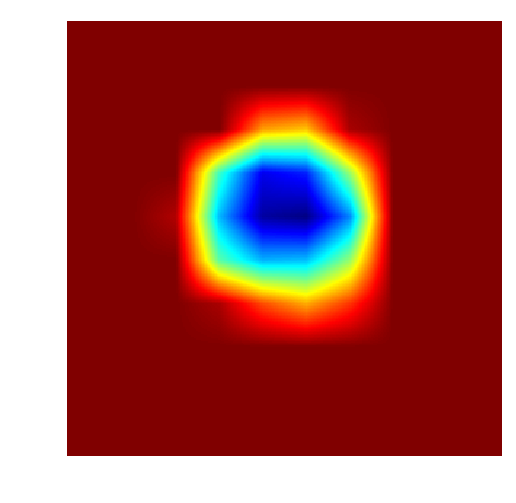

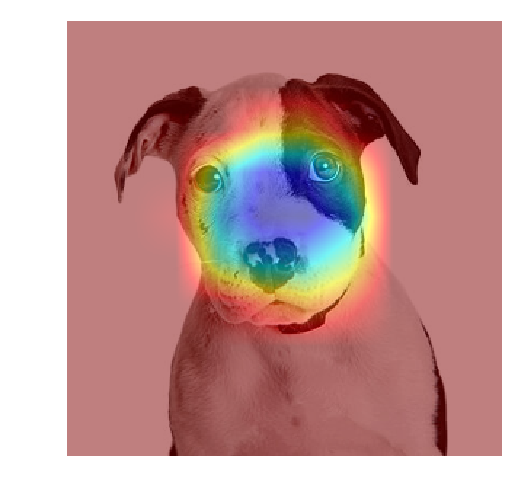

In [73]:
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)


ppi = lambda x: ppix(np.expand_dims(image.img_to_array(x), axis=0))

_ = gradcam(xcep,"block14_sepconv2",dog,180,preprocess_func=ppi,show=True,open_cv=False)

## RDJ with  InceptionResNetV2 and Xception net

- For some reason RDJ hates inceptionResnetV2 and won't let his sunglasses be detected

In [0]:
rdj = io.imread("rdj_glasses.jpg")
rdj = cv2.resize(rdj, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)


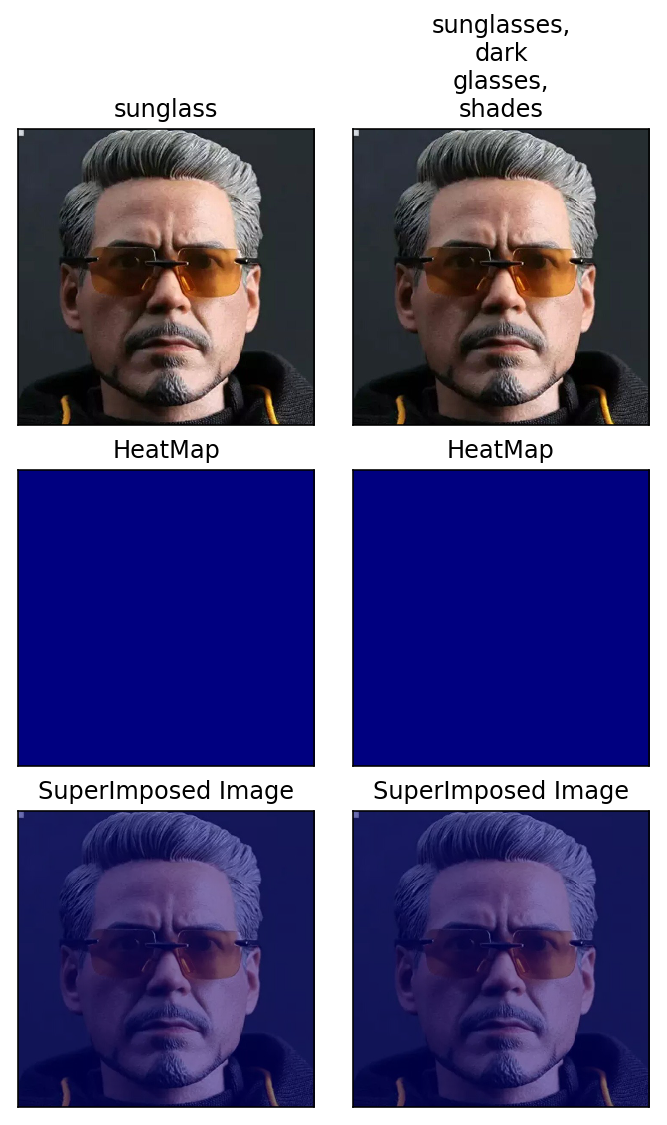

In [82]:
show_examples_with_gradcam(inceptionResnet,"conv2d_202",[rdj,rdj],[836, 837],preprocess_func=pp,classes=get_imagenet_labels())

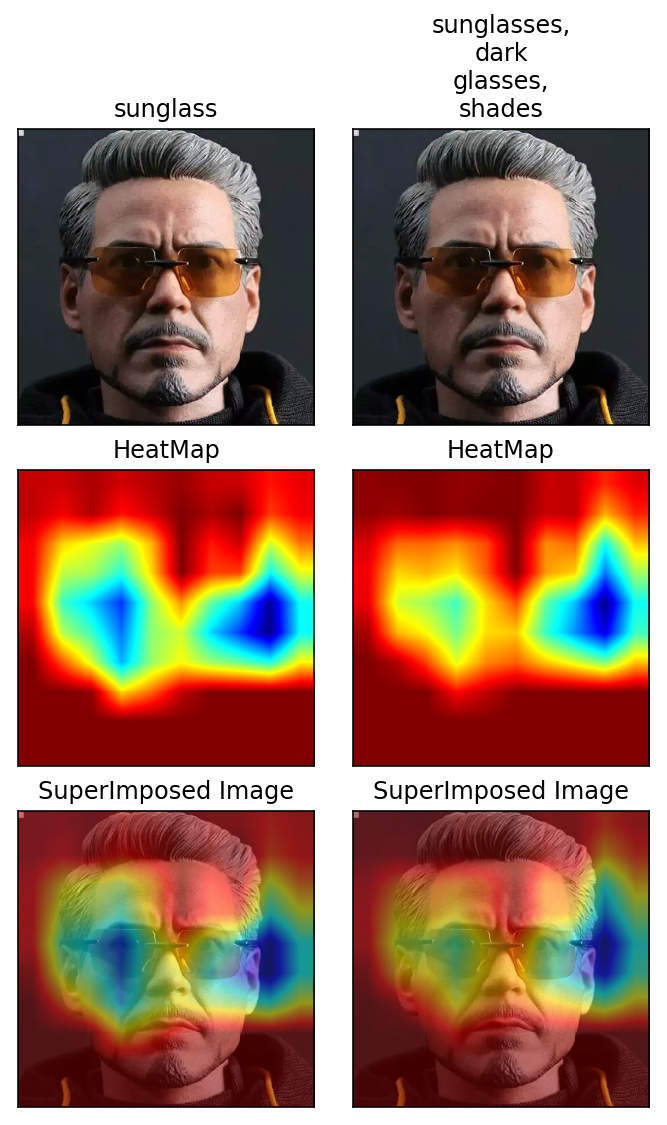

In [76]:
show_examples_with_gradcam(xcep,"block14_sepconv2",[rdj,rdj],[836, 837],preprocess_func=pp,classes=get_imagenet_labels())

# Part 2

Explanation: Working of Conv Operation in 3D is same as 2D. The filters will be 4 dims (4th dim as channels) and move in 3D space, while in 2D they were 3 dims (3rd dim as channel) and moved in 2D space. 

Since in 3D conv filters move in 3D so when we use stride=2 they reduce dimension of all 3 Dims. In the table on left they are only specifying the Image Dims in the 1st 2 columns, while the features column specifies channels.

For Calculations I used session 7 formulas only. Information about which layer is strides=2 was mentioned in 

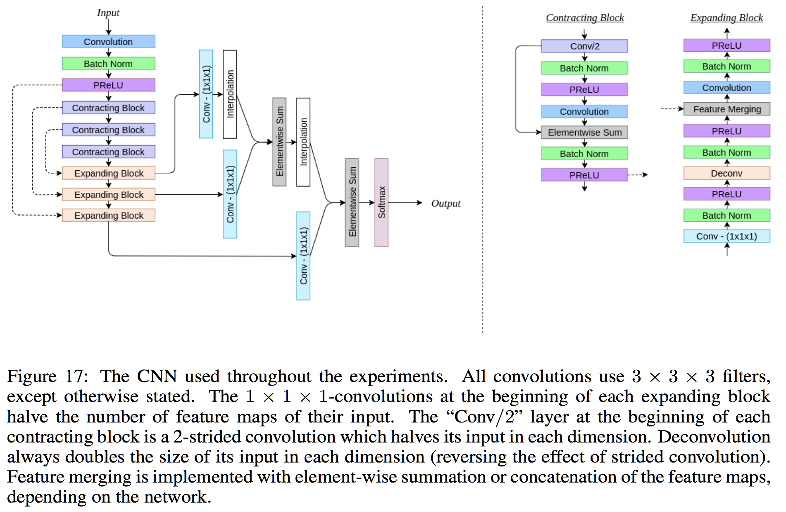

In [88]:
arch = io.imread("arch_details.png")
arch = cv2.resize(arch, dsize=(786, 512), interpolation=cv2.INTER_CUBIC)
cv2_imshow(arch)

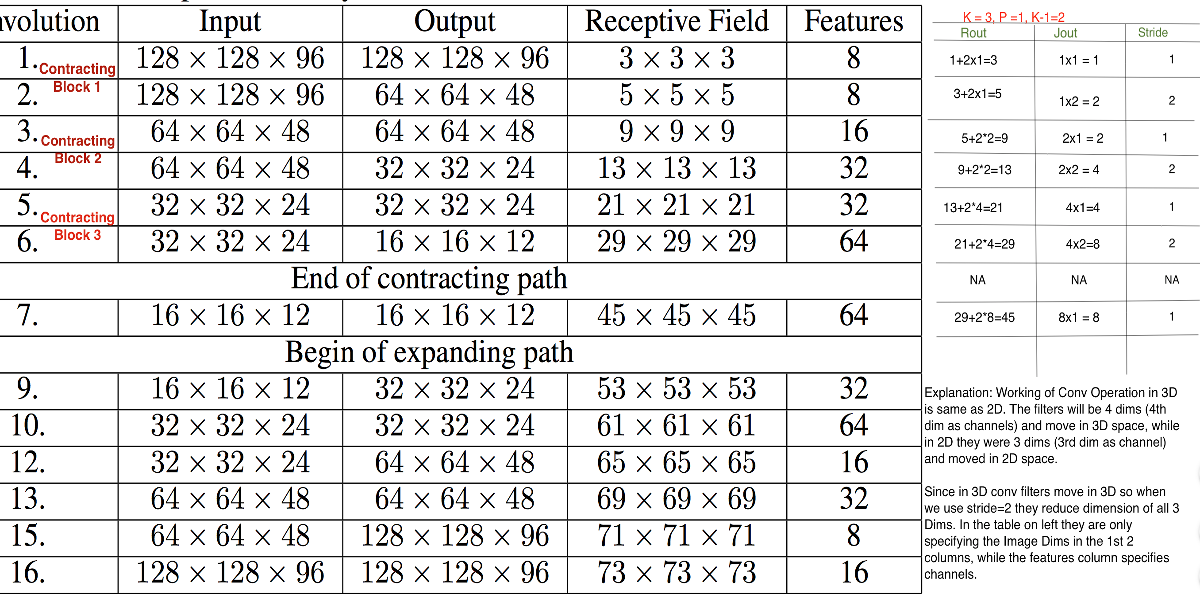

In [94]:
conv_shape = io.imread("medical_imaging_conv.png")
conv_shape = cv2.resize(conv_shape, dsize=(1200, 600), interpolation=cv2.INTER_CUBIC)
cv2_imshow(cv2.cvtColor(conv_shape, cv2.COLOR_BGR2RGB))